## Import Libraries, Data:

In [ ]:
## TODO uncomment before submission && remove unused & twice-imported libraries
# !pip install scikit
!pip install surprise


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import random
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import ndcg_score
import pandas as pd
from itertools import combinations
from scipy.stats import pearsonr
from surprise import Prediction
from surprise import BaselineOnly, KNNBasic, NMF, SVD, accuracy
import statistics
from surprise.model_selection import KFold
import math

In [ ]:
### u.data extracted from the download on: https://grouplens.org/datasets/movielens/100k/
# Read in data
data = pd.read_csv("u.data", sep="\t", names=["userId", "movieId", "rating", "timestamp"])
data = data.drop(columns="timestamp")

In [ ]:
data

,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


## Split & Prep Data:

In [ ]:
from sklearn.model_selection import train_test_split
import copy

# Extract valuable pivot from data
ratings_pivot = data.pivot(index='userId', columns='movieId', values='rating')

# Extract set of all userIds, movieIds in data
uidSet, iidSet = set(), set()
for i, row in data.iterrows():
    uidSet.add(row["userId"])
    iidSet.add(row["movieId"])

uidList, iidList = list(uidSet), list(iidSet)

# Split data
random_seed = 2024
trainset, testset = train_test_split(data, test_size=0.95, random_state=random_seed)
print(trainset)

       userId  movieId  rating
50570     630      272       5
49111     587      271       4
91330     456      109       3
6227      318      248       3
98432     158      125       3
...       ...      ...     ...
47643     686      134       5
35456     450      340       4
51808     610      735       3
52730     328      133       5
7816      152      790       5

[5000 rows x 3 columns]


In [ ]:
from surprise.model_selection.split import train_test_split
from surprise import Dataset

surprise_data = Dataset.load_builtin('ml-100k')
surprise_trainset, surprise_testset = train_test_split(surprise_data, test_size=0.95, random_state=random_seed)

### Baseline Class for Recommenders:

In [ ]:
import random
from collections import defaultdict

# Base class for our multi-arm bandit ensembles (abstract)
class BaseRecommender:
    def __init__(self, trainData, iids, uids, arms):
        pass

    def addUid(self, uid):
        self.uids.add(uid)

    def addIid(self, iid):
        self.iids.add(iid)

    def add_train_data(self, uid, iid, rating, armUsed, wasCorrect=False):
        if uid not in self.dataToAdd:
            self.dataToAdd[uid] = {}
        if iid not in self.dataToAdd[uid]:
            if armUsed != "":
                self.dataToAdd[uid][iid] = {"rating": rating, "armUsed": armUsed, "wasCorrect": wasCorrect}
            else:
                self.dataToAdd[uid][iid] = {"rating": rating, "armUsed": "Solo Alg", "wasCorrect": wasCorrect}
        else:
            # If the key already exists, update the values
            self.dataToAdd[uid][iid]["rating"] = rating
            self.dataToAdd[uid][iid]["wasCorrect"] = wasCorrect
            if armUsed != "":
                self.dataToAdd[uid][iid]["armUsed"] = armUsed
            else:
                self.dataToAdd[uid][iid]["armUsed"] = "Solo Alg"

    # Retrieves rating for a uid, iid pair
    def get_rating(self, uid, iid):
        if uid in self.surprise_train.ur and any(int(iid) == tup[0] for tup in self.surprise_train.ur[uid]):
            for item_id, rating in self.surprise_train.ur[uid]:
                if int(iid) == item_id:
                    return rating
        return None
        
    # Blacklists all training data ratings so they cannot be recommended
    def blacklist_train_data(self):
        for _,row in self.trainData.iterrows():
            self.blacklist_item_from_user(row["userId"], row["movieId"])
    
    def blacklist_item_from_user(self, uid, iid):
        if uid in self.blacklist:  # User already has a blacklisted movie - append
            if isinstance(self.blacklist[uid], list):
                self.blacklist[uid].append(iid)
            else:
                self.blacklist[uid] = [self.blacklist[uid], iid]
        else:  # Uid is not in blacklist already
            self.blacklist[uid] = [iid]

    def fit(self):
        for algName, alg in self.arms.items():
            alg.fit(self.trainData)  # Fit alg

    def chooseArm(self, uid):
        pass

    # Recs to a list of uids
    def predict(self, uids):  # uids should be str type
        pass

    def update(self):
        pass

## Individual Algs:

In [ ]:
import random
from collections import defaultdict
from surprise.prediction_algorithms.predictions import Prediction
import copy

# Shell class to match the return value format of the KNN and SVD
class EstimateValue:
    def __init__(self, est):
        self.est = est

class Popularity(BaseRecommender):
    def __init__(self, trainData, surprise_train=None):
        self.trainData = trainData
        self.movie_rating_counts = defaultdict(lambda: [0, 0, 0, 0, 0])
        self.most_common_overall = 0
        self.counts_to_add = {}
        self.blacklist = {}
        self.blacklist_train_data()  # Ensure user,movie pairs in training data aren't recommended

        self.iids = iidList
        self.uids = uidList
        self.dataToAdd = {}
        

    def fit(self, trainset):
        allRatingCounts = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
        for _, iid, rating in trainset.all_ratings():
            if not (np.isnan(rating)):
                self.movie_rating_counts[iid][int(rating) - 1] += 1
                allRatingCounts[rating] += 1

        # Get most common rating overall as a fallback rating (not needed but fun to have)
        self.most_common_overall = max(allRatingCounts, key=allRatingCounts.get)

    def predict(self, uid, iid):
        if iid in self.movie_rating_counts:  # If movie has been rated before 
            rating_counts = self.movie_rating_counts[iid]
            # Count number of 4s and 5s
            count_4_5 = rating_counts[3] + rating_counts[4]
            return EstimateValue(est=count_4_5)
        
        else:  # If ratings for movie not found in training set, predict most_common_overall rating
            return EstimateValue(est=self.most_common_overall)
   

    def test(self, testset):
        # print(f"Type for popularity's testset: {type(testset)}")
        preds = []
        for uid, iid, rating in testset:
            iid = int(iid)
            if iid in self.movie_rating_counts:
                rating_counts = self.movie_rating_counts[iid]
                self.counts_to_add[iid] = rating_counts
                most_popular_rating = rating_counts.index(max(rating_counts)) + 1
                preds.append(Prediction(uid=uid, iid=iid, r_ui=rating, est=most_popular_rating, details={'was_impossible': False}))
            else:  # If movie not found in training set, predict most common val
                preds.append(Prediction(uid=uid, iid=iid, r_ui=rating, est=self.most_common_overall, details={'was_impossible': True}))

        # Add counts_to_add to movie_rating_counts
        for movie_id, counts in self.counts_to_add.items():
            if movie_id in self.movie_rating_counts:
                self.movie_rating_counts[movie_id] = [old_count + new_count for old_count, new_count in zip(self.movie_rating_counts[movie_id], counts)]
            else:
                self.movie_rating_counts[movie_id] = counts

        return preds

    def recommend(self, uids):
        recs, item_ratings = {}, {}
        for uid in uids:
        # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            for iid in self.iids:
                if uid not in self.blacklist or str(iid) not in self.blacklist[uid]:  # If item can be rec'd to this user
                    # iid = self.trainData.to_raw_iid(iid)
                    rating = ratings_pivot.loc[uid, iid]
                    predicted_rating = self.predict(uid=uid, iid=iid).est
                    
                    item_ratings[iid] = predicted_rating

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, 'est': v}

        for rec in recs:
            self.blacklist_item_from_user(uid=rec, iid=recs[rec]['iid'])

        return recs

    def update(self):
        # Update a, b for each alg
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():  
                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]

            # Ensure item is not recommended again to the same user
            self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}


popularity_model = Popularity(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
popularity_model.fit(copy.deepcopy(surprise_trainset))
prediction = popularity_model.predict(115, 17)
print(popularity_model.recommend([115]))
print(prediction.est)
print("new")


{115: {'iid': '89', 'est': 4}}
{115: {'iid': '262', 'est': 4}}
6
new


In [ ]:
import random
'''
Random: Random. Not used in bandits
'''
from surprise.prediction_algorithms.predictions import Prediction
import random

class Random(BaseRecommender):
    def __init__(self, trainData, surprise_train):
        self.random_predictions = {}
        self.estimations = []
        self.trainData = trainData
        self.movie_rating_counts = defaultdict(lambda: [0, 0, 0, 0, 0])
        self.most_common_overall = 0
        self.counts_to_add = {}
        self.blacklist = {}
        self.blacklist_train_data()
        self.iids = iidList
        self.dataToAdd = {}
        self.uids = uidList
        self.surprise_train = surprise_train
        self.rand_count = {uid: {"numCorrect": 0, "numTotal": 0} for uid in self.uids}
 
    # Just here so it doesn't mess up the training loop
    def fit(self, trainset):
        return None

    def test(self, testset):
        for userId, movieId, true_rating in testset:
            true_rating = self.get_rating(userId, movieId)
            self.estimations.append(Prediction(uid=userId, iid=movieId, r_ui=true_rating, est=random.randint(1,5), details={'was_impossible': False}))

        return self.estimations

    def predict(self, uid, iid):
        return EstimateValue(est=random.randint(1,5))

    def recommend(self, uids):
        recs, item_ratings = {}, {}
        for uid in uids:
        # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            for iid in self.iids:
                if uid not in self.blacklist or str(iid) not in self.blacklist[uid]:  # If item can be rec'd to this user
                    # iid = self.trainData.to_raw_iid(iid)
                    rating = self.get_rating(uid, iid)
                    predicted_rating = self.predict(uid, iid).est
                    item_ratings[iid] = predicted_rating

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            # print(item_ratings.items())
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, 'est': v}

        for rec in recs:
        #     if recs[rec]['iid'] not
            self.blacklist_item_from_user(uid=rec, iid=recs[rec]['iid'])

        return recs

    def update(self):
        # Update a, b for each alg
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():
                if data["wasCorrect"] == True:  # Prediction was correct
                    self.rand_count[uid]["numCorrect"] += 1
                self.rand_count[uid]["numTotal"] += 1
    
                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]

            # Ensure item is not recommended again to the same user
            self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}

random_model = Random(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
random_model.fit(copy.deepcopy(surprise_trainset))
prediction = random_model.predict(115, 17)
print(random_model.recommend([115]))
print(random_model.recommend([115]))
print(prediction.est)

{115: {'iid': '1', 'est': 2}}
{115: {'iid': '4', 'est': 1}}
1


In [ ]:
class ExtendKNNBasic(KNNBasic, BaseRecommender):
    def __init__(self, trainData, surprise_train, k=40, min_k=1, sim_options={}, verbose=True):
        self.blacklist = {}
        self.dataToAdd = {}
        self.iids = iidList
        self.uids = uidList
        self.trainData = trainData
        self.surprise_train = surprise_train
        self.blacklist_train_data()
        self.knn_count = {uid: {"numCorrect": 0, "numTotal": 0} for uid in self.uids}
        # print(self.blacklist)
        super().__init__(k, min_k, sim_options, verbose)
    
    def fit(self, trainset):
        return super().fit(trainset)

    def estimate(self, u, i):
        return super().estimate(u, i)

    def recommend(self, uids):
        recs, item_ratings = {}, {}
        for uid in uids:
        # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            for iid in self.iids:
                if np.int64(uid) not in self.blacklist or iid not in self.blacklist[uid]:  # If item can be rec'd to this user
                    rating = self.get_rating(uid=uid, iid=iid)
                    
                    # Need this or else .predict() will return the same prediction for all movies
                    try:
                        user_id = surprise_trainset.to_raw_uid(uid)
                    except:
                        user_id = uid
                    try:
                        item_id = surprise_trainset.to_raw_iid(iid)
                    except:
                        item_id = iid

                    if rating:
                        predicted_rating = self.predict(uid=user_id, iid=item_id, r_ui=rating).est
                    else:
                        predicted_rating = self.predict(uid=user_id, iid=item_id).est
                    item_ratings[iid] = predicted_rating
                # else:
                #     print(f"{uid} {iid} ARE BANISHED TO THE SHADOW REALM")

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            # print(item_ratings.items())
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, 'est': v}

        for rec in recs:
        #     if recs[rec]['iid'] not
            self.blacklist_item_from_user(uid=np.int64(rec), iid=np.int64(recs[rec]['iid']))

        return recs

    def update(self):
        # Update a, b for each alg
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():
                if data["wasCorrect"] == True:  # Prediction was correct
                    self.knn_count[uid]["numCorrect"] += 1
                self.knn_count[uid]["numTotal"] += 1
    
                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]

            # Ensure item is not recommended again to the same user
            self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}


knn = ExtendKNNBasic(k=len(uidList), sim_options={'name': 'cosine', 'user_based': True}, trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
knn.fit(copy.deepcopy(surprise_trainset))
# prediction = knn.predict(uid=str(115), iid=str(17), r_ui)
print(knn.recommend([0]))
print(knn.recommend([0]))
print(prediction.est)
print("new")

# dynamic_ensemble_sampler = DynamicEnsemble(trainset.copy(deep=True), iidSet, uidSet, dynamicEnsembleArms)
# dynamic_ensemble_sampler.fit()
# print(dynamic_ensemble_sampler.predict([115, 10, 189]))  # Recommend for these 3 userIds

# dynamic_ensemble_sampler.add_train_data(2, 2, 0, "fakeArm", wasCorrect=True)
# dynamic_ensemble_sampler.update()
# print(dynamic_ensemble_sampler.trainData)


Computing the cosine similarity matrix...
Done computing similarity matrix.
{0: {'iid': '33', 'est': 3.5038}}
{0: {'iid': '36', 'est': 3.5038}}
1
new


In [ ]:
# TODO: Investigate self.predict(), gives same value every time
class ExtendSVD(SVD, BaseRecommender):
    def __init__(self, trainData, surprise_train, n_factors=100, n_epochs=20, biased=True, init_mean=0,
                init_std_dev=.1, lr_all=0.005, reg_all=.02, lr_bu=None, lr_bi=None, lr_pu=None, lr_qi=None,
                 reg_bu=None, reg_bi=None, reg_pu=None, reg_qi=None, random_state=None, verbose=False):
        self.blacklist = {}
        self.dataToAdd = {}
        self.iids = iidList
        self.uids = uidList
        self.trainData = trainData
        self.surprise_train = surprise_train
        self.blacklist_train_data()
        self.svd_count = {uid: {"numCorrect": 0, "numTotal": 0} for uid in self.uids}
        # print(self.blacklist)
        super().__init__(n_factors, n_epochs, biased, init_mean, init_std_dev, lr_all, reg_all, lr_bu, lr_bi,
                        lr_pu, lr_qi, reg_bu, reg_bi, reg_pu, reg_qi, random_state, verbose)
    
    def fit(self, trainset):
        return super().fit(trainset)

    def estimate(self, u, i):
        return super().estimate(u, i)

    def recommend(self, uids):
        recs, item_ratings = {}, {}
        for uid in uids:
        # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            for iid in self.iids:
                if np.int64(uid) not in self.blacklist or iid not in self.blacklist[uid]:  # If item can be rec'd to this user
                    rating = self.get_rating(uid=uid, iid=iid)
                    
                    # Need this or else .predict() will return the same prediction for all movies
                    try:
                        user_id = surprise_trainset.to_raw_uid(uid)
                    except:
                        user_id = uid
                    try:
                        item_id = surprise_trainset.to_raw_iid(iid)
                    except:
                        item_id = iid

                    # TODO: Decide if we still need this
                    if rating:
                        predicted_rating = self.predict(uid=user_id, iid=item_id, r_ui=rating).est
                    else:
                        predicted_rating = self.predict(uid=user_id, iid=item_id).est
                    item_ratings[iid] = predicted_rating
                # else:
                #     print(f"{uid} {iid} ARE BANISHED TO THE SHADOW REALM")

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            # print(item_ratings.items())
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, 'est': v}

        for rec in recs:
        #     if recs[rec]['iid'] not
            self.blacklist_item_from_user(uid=np.int64(rec), iid=np.int64(recs[rec]['iid']))

        return recs

    def update(self):
        # Update a, b for each alg
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():
                if data["wasCorrect"] == True:  # Prediction was correct
                    self.svd_count[uid]["numCorrect"] += 1
                self.svd_count[uid]["numTotal"] += 1
    
                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]

            # Ensure item is not recommended again to the same user
            self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}

svd = ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1)
svd.fit(copy.deepcopy(surprise_trainset))
prediction = svd.predict(uid=str(115), iid=str(17), r_ui=None)
print(svd.recommend([0]))
print(prediction.est)
print("new")
svd_2 = SVD(n_factors=20, n_epochs=20, lr_all=0.1)
svd_2.fit(surprise_trainset)
prediction = svd_2.predict(uid=str(115), iid=str(17), r_ui=None)
print(prediction.est)

{0: {'iid': '686', 'est': 2.8470038636968598}}
2.6047410359023573
new
2.746235292882358


## Bandit Declarations:

In [ ]:
'''
Dynamic Emsemble:
At start of each epoch, randomly splits existing training data into (train, test) & chooses alg with
best performance to use for everything that epoch.

Arms have format: { "armName" : { "uid" : {"numCorrect" : 0, "numTotal" : 0} }, ...}
'''
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split

# A specific train-test split wasn't specified in paper, so the default 80/20 split was used
class DynamicEnsemble(BaseRecommender):
    def __init__(self, trainData, iids, uids, arms):
        self.trainData = trainData
        self.uids = uids
        self.iids = iids
        self.arms = arms

        self.curArm = None
        self.dataToAdd = defaultdict(dict)
        self.blacklist = defaultdict(dict)

        self.blacklist_train_data()


    def fit(self):
        # Get surprise trainset
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(self.trainData[['userId', 'movieId', 'rating']], reader)
        trainset, testset = surprise_train_test_split(data, test_size=0.2) # Surprise bug: cannot = 0

        avgPrecs, numPrecs = {}, 0

        # For each alg, split, fit, & get avg precision
        for armName, arm in self.arms.items():
            avgPrecs[armName] = 0.0  # Initialize average precision for the current arm
            arm.fit(trainset)
            predictions = arm.test(testset)
            for x,y,z in testset:
                if z is None:
                    print(x,y,z)
            for pred in predictions:
                # print(f"TYPES: actual: {type(pred.r_ui)}, predicted: {type(pred.est)}")
                if pred.r_ui is not None and pred.est is not None:
                    if not np.isnan(pred.r_ui) and not np.isnan(pred.est):  # Extra safety check
                        if round(pred.r_ui) == round(pred.est):  # if correct
                            avgPrecs[armName] += 1
                        numPrecs += 1
            if numPrecs > 0:
                avgPrecs[armName] /= numPrecs
            else:
                avgPrecs[armName] = 0
        self.curArm = str(max(avgPrecs, key=avgPrecs.get))  # Select arm with highest average precision


    def chooseArm(self, uid):
        # Determined for entire epoch within fit() function
        pass


    # Recs to a list of uids
    def predict(self, uids):  # uids should be str type

        recs, item_ratings = {}, {}
        for uid in uids:
            # Choose arm & predict output for each item
            self.chooseArm(uid)
            for iid in self.iids:
                if iid not in self.blacklist[uid]:  # If item can be rec'd to this user
                    predicted_rating = self.arms[self.curArm].predict(uid=uid, iid=iid).est
                    item_ratings[iid] = predicted_rating

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            # print(item_ratings.items())
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, "armUsed" : self.curArm, 'est': v}

        return recs

    def update(self):
        # Update training data, blacklist
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():  # Iterate through the nested iid_data dictionary

                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]

                # Ensure item is not recommended again to the same user
                self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}


dynamicEnsembleArms = {
    "KNN": ExtendKNNBasic(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': ExtendSVD(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "mostPop": Popularity(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
}

dynamic_ensemble_sampler = DynamicEnsemble(trainset.copy(deep=True), iidSet, uidSet, dynamicEnsembleArms)
dynamic_ensemble_sampler.fit()
print(dynamic_ensemble_sampler.predict([115, 10, 189]))  # Recommend for these 3 userIds


Computing the cosine similarity matrix...
Done computing similarity matrix.
{115: {'iid': '33', 'armUsed': 'KNN', 'est': 3.52075}, 10: {'iid': '13', 'armUsed': 'KNN', 'est': 3.5}, 189: {'iid': '20', 'armUsed': 'KNN', 'est': 3.52075}}


In [ ]:
'''
Thompson:
Heuristic for choosing actions that
address the exploration/exploitation
dilemma in the multi-armed bandit problem

Probs as a beta distribution:
a and b are the number of successful and unsuccessful recommendations from the alg.

We sample a val given the a, b distribution. Alg with the highest sampled val gets picked.
np.random.beta(a, b)

trainData = df of ratings
'''

class Thompson(BaseRecommender):
    def __init__(self, trainData, iids, uids, thompson_probs, arms):
        self.trainData = trainData
        self.uids = uids
        self.iids = iids
        self.thompson_probs = thompson_probs
        self.arms = arms

        # Fill in thompsonProbs for each uid that exists
        for algName, alg in self.arms.items():
            if algName not in self.thompson_probs:
                self.thompson_probs[algName] = {}
            for uid in self.uids:
                if uid not in self.thompson_probs[algName]:
                    self.thompson_probs[algName][uid] = {"a": 1000, "b": 1}

        self.curArm = None
        self.dataToAdd = defaultdict(dict)
        self.blacklist = defaultdict(dict)

        self.blacklist_train_data()

    def fit(self):
      # Convert to surprise trainset
      reader = Reader(rating_scale=(1, 5))
      data = Dataset.load_from_df(self.trainData[['userId', 'movieId', 'rating']], reader)
      data, testset = surprise_train_test_split(data, test_size=0.000000001) # Surprise bug: test_size cannot = 0

      for algName, alg in self.arms.items():
        print(algName)
        alg.fit(data)

    def chooseArm(self, uid):
        # Sample from each distribution, pick arm with highest sample
        armSamples = {}
        for algName, params in self.thompson_probs.items():
            armSamples[algName] = np.random.beta(params[uid]["a"], params[uid]["b"])
        self.curArm = max(armSamples, key=armSamples.get)
        return self.curArm

    
    # Recs to a list of uids
    def predict(self, uids):  # uids should be str type

        recs, item_ratings = {}, {}
        for uid in uids:
            # Choose arm & predict output for each item
            self.chooseArm(uid)
            for iid in self.iids:
                if iid not in self.blacklist[uid]:  # If item can be rec'd to this user
                    # iid = self.trainData.to_raw_iid(iid)
                    predicted_rating = self.arms[self.curArm].predict(uid=uid, iid=iid).est
                    item_ratings[iid] = predicted_rating

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, "armUsed" : self.curArm}

        return recs

    def update(self):
        # Update a, b for each alg
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():
                if data["wasCorrect"] == True:  # Prediction was correct
                    self.thompson_probs[self.curArm][uid]["a"] += 1
                else:  # Incorrect prediction
                    self.thompson_probs[self.curArm][uid]["b"] += 1
    
                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]

            # Ensure item is not recommended again to the same user
            self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}


# thompsonArms = {
#     "KNN": KNNBasic(k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
#     'SVD': SVD(n_factors=20, n_epochs=20, lr_all=0.1),
#     "mostPop": Popularity()
# }
# thompsonProbs = {}
# for algName,_ in thompsonArms.items():
#     thompsonProbs[algName] = {}

# thompson_sampler = Thompson(trainset.copy(deep=True), iidSet, uidSet, thompsonProbs, thompsonArms)
# thompson_sampler.fit()
# print(thompson_sampler.predict([115, 10, 189]))  # Recommend for these 3 userIds


In [ ]:
'''
ε-Greedy Bandit:
Pick best alg probability = 1 - ε
All other algs prob: ε / Number of other algs
ε = 0.1
trainData = df of ratings

'''
class EpsilonGreedy(BaseRecommender):
    def __init__(self, trainData, iids, uids, eps_counts, arms, eps=0.1):
        self.trainData = trainData
        self.uids = uids
        self.iids = iids
        self.eps_counts = eps_counts
        self.arms = arms
        self.eps = eps

        # Initialize counts for each arm and user
        for algName, alg in self.arms.items():
            self.eps_counts[algName] = {uid: {"numCorrect": 0, "numTotal": 0} for uid in self.uids}

        self.curArm = None
        self.dataToAdd = defaultdict(dict)
        self.blacklist = defaultdict(dict)

        self.blacklist_train_data()


    def fit(self):
      # Get surprise trainset
      reader = Reader(rating_scale=(1, 5))
      data = Dataset.load_from_df(self.trainData[['userId', 'movieId', 'rating']], reader)
      data, testset = surprise_train_test_split(data, test_size=0.00000001) # Surprise bug: cannot be 0

      for algName, alg in self.arms.items():
        alg.fit(data)


    def chooseArm(self, uid):
        # Get alg with the best precision for this user
        precs = {}
        for alg in self.arms:
            if self.eps_counts[alg][uid]["numTotal"] == 0:  
                precs[alg] = 0
            else:  
                precs[alg] = self.eps_counts[alg][uid]["numCorrect"] / self.eps_counts[alg][uid]["numTotal"]
        bestArm = max(precs, key=precs.get)

        # Pick an arm
        x = random.uniform(0, 1)
        if x <= self.eps and len(self.arms) > 1:
            self.curArm = random.choice([arm for arm in self.arms.keys() if arm != bestArm])
        else:
            self.curArm = bestArm
    

    # Recs to a list of uids
    def predict(self, uids):  # uids should be str type

        recs, item_ratings = {}, {}
        for uid in uids:
            # Choose arm & predict output for each item
            self.chooseArm(uid)
            for iid in self.iids:
                if iid not in self.blacklist[uid]:  # If item can be rec'd to this user
                    # iid = self.trainData.to_raw_iid(iid)
                    predicted_rating = self.arms[self.curArm].predict(uid=uid, iid=iid).est
                    item_ratings[iid] = predicted_rating

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            # print(item_ratings.items())
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, "armUsed" : self.curArm}

        return recs

    def update(self):
        # Update a, b for each alg
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():
                if data["wasCorrect"] == True:  # Prediction was correct
                    self.eps_counts[self.curArm][uid]["numCorrect"] += 1
                self.eps_counts[self.curArm][uid]["numTotal"] += 1
    
                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]
                
            # Ensure item is not recommended again to the same user
            self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}



# epsGreedyArms = {
#     "KNN": KNNBasic(k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
#     'SVD': SVD(n_factors=20, n_epochs=20, lr_all=0.1),
#     "mostPop": Popularity()
# }
# epsGreedyCounts = {}
# for algName,_ in thompsonArms.items():
#     epsGreedyCounts[algName] = {}

# epsilon_sampler = EpsilonGreedy(trainset.copy(deep=True), iidSet, uidSet, epsGreedyCounts, epsGreedyArms)
# epsilon_sampler.fit()

# print(epsilon_sampler.predict([115, 10, 189]))  # Recommend for these 3 userIds

# epsGreedyCounts = { "KNN" : { 115 : {"numCorrect" : 0, "numTotal" : 0} }, "SVD" : { "uid" : {"numCorrect" : 0, "numTotal" : 0} }, "mostPop" : { "uid" : {"numCorrect" : 0, "numTotal" : 0} } }

In [ ]:
'''
class UCBBandit:
Upper-confidence bound bandit
'''

class UCBBandit(BaseRecommender):
    def __init__(self, trainData, iids, uids, arms, counts={}, rewards={}):
        self.trainData = trainData
        self.uids = uids
        self.iids = iids
        self.ucb_counts = counts
        self.ucb_rewards = rewards
        self.arms = arms
        self.curArm = None
        self.dataToAdd = defaultdict(dict)
        self.blacklist = defaultdict(dict)

        self.blacklist_train_data()

        # Init counts & rewards
        for algName, _ in self.arms.items():
            if algName not in self.ucb_counts:
                self.ucb_counts[algName] = {}
            if algName not in self.ucb_rewards:
                self.ucb_rewards[algName] = {}
            for uid in self.uids:
                self.ucb_counts[algName][uid] = 0
                self.ucb_rewards[algName][uid] = 0

    def fit(self):
      # Convert to surprise trainset
      reader = Reader(rating_scale=(1, 5))
      data = Dataset.load_from_df(self.trainData[['userId', 'movieId', 'rating']], reader)
      data, testset = surprise_train_test_split(data, test_size=0.000000001) # Surprise bug: test_size cannot = 0

      for algName, alg in self.arms.items():
        alg.fit(data)

    def chooseArm(self, uid):
        max_ucb = float('-inf')
        for algName, _ in self.arms.items():
            arm_reward = self.ucb_rewards[algName][uid]
            arm_count = self.ucb_counts[algName][uid]
            if arm_count == 0:  # If arm hasn't been used for this uid before
                self.curArm = algName
                break
            ucb_value = arm_reward / arm_count + np.sqrt(2 * np.log(len(self.trainData)) / arm_count)
            if ucb_value > max_ucb:
                max_ucb = ucb_value
                self.curArm = algName

    
    # Recs to a list of uids
    def predict(self, uids):  # uids should be str type

        recs, item_ratings = {}, {}
        for uid in uids:
            # Choose arm & predict output for each item
            self.chooseArm(uid)
            for iid in self.iids:
                if iid not in self.blacklist[uid]:  # If item can be rec'd to this user
                    # iid = self.trainData.to_raw_iid(iid)
                    predicted_rating = self.arms[self.curArm].predict(uid=uid, iid=iid).est
                    item_ratings[iid] = predicted_rating

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, "armUsed" : self.curArm}

        return recs

    def update(self):
        # Update counts and rewards for the chosen arm based on the added data
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():
                if data["wasCorrect"] == True:  # Prediction was correct
                    self.ucb_counts[self.curArm][uid] += 1
                    self.ucb_rewards[self.curArm][uid] += 1
                else:  # Incorrect prediction
                    self.ucb_counts[self.curArm][uid] += 1
        
                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]
                    
            # Ensure item is not recommended again to the same user
            self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}

# ucbArms = {
#     "KNN": KNNBasic(k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
#     'SVD': SVD(n_factors=20, n_epochs=20, lr_all=0.1),
#     "mostPop": Popularity()
# }
# ucb_sampler = UCBBandit(trainset.copy(deep=True), iidSet, uidSet, ucbArms)
# ucb_sampler.fit()
# print(ucb_sampler.predict([115, 10, 189]))  # Recommend for these 3 userIds

# ucb_sampler.add_train_data(2, 2, 0, "fakeArm", wasCorrect=True)
# ucb_sampler.update()
# print(ucb_sampler.trainData)

In [ ]:
class RandomEnsemble(DynamicEnsemble):
    def __init__(self, trainData, iids, uids, arms):
        self.trainData = trainData
        self.uids = uids
        self.iids = iids
        self.arms = arms

        self.curArm = None
        self.dataToAdd = defaultdict(dict)
        self.blacklist = defaultdict(dict)

        self.blacklist_train_data()
        super().__init__(trainData, iids, uids, arms)


    def fit(self):
        # Get surprise trainset
        reader = Reader(rating_scale=(1, 5))
        data = Dataset.load_from_df(self.trainData[['userId', 'movieId', 'rating']], reader)
        trainset, testset = surprise_train_test_split(data, test_size=0.2) # Surprise bug: cannot = 0

        # For each alg, split, fit, & get avg precision
        for armName, arm in self.arms.items():
            arm.fit(trainset)


    def chooseArm(self, uid):
        self.curArm = random.choice(list(self.arms.keys()))

    # Recs to a list of uids
    def predict(self, uids):  # uids should be str type

        recs, item_ratings = {}, {}
        for uid in uids:
            # Choose arm & predict output for each item
            self.chooseArm(uid)
            for iid in self.iids:
                if iid not in self.blacklist[uid]:  # If item can be rec'd to this user
                    # iid = self.trainData.to_raw_iid(iid)
                    predicted_rating = self.arms[self.curArm].predict(uid=uid, iid=iid).est
                    item_ratings[iid] = predicted_rating

            # Find most confident prediction to use as rec
            topIid, topVal  = "", float('-inf')
            for k,v in item_ratings.items():  
                if v > topVal:
                    topVal = v
                    topIid = str(k)
                recs[uid] = {"iid" : topIid, "armUsed" : self.curArm}

        return recs


    def update(self):
        # Update counts and rewards for the chosen arm based on the added data
        for uid, iid_data in self.dataToAdd.items():
            for iid, data in iid_data.items():
                # Add entry to training data                
                rating = data["rating"]
                if not np.isnan(rating):
                    self.trainData.loc[len(self.trainData.index)] = [int(uid), int(iid), rating]
                    
            # Ensure item is not recommended again to the same user
            self.blacklist_item_from_user(int(uid), int(iid))

        # Clear queued data, update iids
        self.dataToAdd = {}

randomArms = {
    "KNN": ExtendKNNBasic(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "mostPop": Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
}
random_sampler = RandomEnsemble(trainset.copy(deep=True), iidSet, uidSet, randomArms)
random_sampler.fit()
print(random_sampler.predict([115, 10, 189]))  # Recommend for these 3 userIds


Computing the cosine similarity matrix...
Done computing similarity matrix.
{115: {'iid': '7', 'armUsed': 'KNN'}, 10: {'iid': '47', 'armUsed': 'KNN'}, 189: {'iid': '57', 'armUsed': 'SVD'}}


## Training and Plotting:
**EVAL APPROACH:**
- Split data into 5% training, 95% testing
- Train
- Arm picks an alg to user for each USER in epoch. (1 usr rating/epoch)
- At end of epoch, if a rating was available for a user,movie pair: add to training set, else discard

In [ ]:
# ## Initialize Arms for figures 1 & 3

# '''
# The bandits don't use random
# '''

# Dynamic Ensemble 
dynamicEnsembleArms = {
    "KNN": ExtendKNNBasic(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "mostPop": Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
    # "random": Random(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
}

dynamic_ensemble_sampler = DynamicEnsemble(trainset.copy(deep=True), iidSet, uidSet, dynamicEnsembleArms)

# Thompson
thompsonArms = {
    "KNN": ExtendKNNBasic(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "mostPop": Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
    # "random": Random(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
}
thompsonProbs = {}
for algName,_ in thompsonArms.items():
    thompsonProbs[algName] = {}

thompson_sampler = Thompson(trainset.copy(deep=True), iidSet, uidSet, thompsonProbs, thompsonArms)

# Epsion Greedy
epsGreedyArms = {
    "KNN": ExtendKNNBasic(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "mostPop": Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
    # "random": Random(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
}
epsGreedyCounts = {}
for algName,_ in thompsonArms.items():
    epsGreedyCounts[algName] = {}

epsilon_sampler = EpsilonGreedy(trainset.copy(deep=True), iidSet, uidSet, epsGreedyCounts, epsGreedyArms)

ucbArms = {
    "KNN": ExtendKNNBasic(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "mostPop": Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
    # "random": Random(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
}
ucb_sampler = UCBBandit(trainset.copy(deep=True), iidSet, uidSet, ucbArms)

randomEnsembleArms = {
    "KNN": ExtendKNNBasic(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "mostPop": Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
    # "random": Random(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))
}

random_ensemble_sampler = RandomEnsemble(trainset.copy(deep=True), iidSet, uidSet, randomEnsembleArms)

In [ ]:
# Initialize solo algorithms for figures 1 & 3

# Random
rand = Random(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))

# Popularity
pop = Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))

# ExtendedKNNBasic
knn = ExtendKNNBasic(k=len(uidList), sim_options={'name': 'cosine', 'user_based': True}, trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset))

# ExtendedSVD
svd = ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1)

In [ ]:
# ### Fig1 & 3 init continued

# # Init vars
# # myAlgsFig1_2 = {"dynamicEnsembleSampler" : dynamic_ensemble_sampler, "thompsonSampler" : thompson_sampler, "epsilonSampler" : epsilon_sampler, "ucbSampler" : ucb_sampler}
myAlgsFig1_2 = {"randomEnsembleSampler" : random_ensemble_sampler}
fig1_cumulative_recall = defaultdict(dict)
fig2_bandit_traffic_ratios = defaultdict(dict)

numCorrect = defaultdict(dict)
numRelevant= 0
numRelevantPrecision = 0

ratings = []
num_epochs = 100


# # Init dictionaries
for algName,alg in myAlgsFig1_2.items():
    numCorrect[algName] = 0
    fig1_cumulative_recall[algName] = []
    if algName in ["thompsonSampler", "epsilonSampler", "ucbSampler"]:
        for armName in alg.arms.keys():
            fig2_bandit_traffic_ratios[algName][armName] = [0 for i in range(num_epochs)]

# # Get the number of relevant items within the initial testset
for (user_id, movie_id, rating) in surprise_testset:
    if rating >= 4:
      numRelevant += 1
      numRelevantPrecision += 1

print("numRelevant: ", numRelevant )
# print(fig2_bandit_traffic_ratios)


numRelevant:  52659


In [ ]:
# # %%capture
# ### Train for Fig1, Fig2


for algName,alg in myAlgsFig1_2.items():
    for epoch in range(num_epochs):
        # Fit, predict
        rewards = {}
        recs = {}
        if algName in ["random", "popularity", "extendedKnnBasic", "extendedSVD"]:
            print(algName)
            alg.fit(copy.deepcopy(surprise_trainset))
            recs = alg.recommend(uidSet)
        else:
            alg.fit()
            recs = alg.predict(uidSet) 

        # For each rec, add to data or blacklist && calculate cumulative recall
        for uid, data in recs.items():
            armUsed = ""

            # Extract
            iid = data["iid"]
            if "armUsed" in data:
                armUsed = data["armUsed"]

            # Update armCounts for fig3
            if algName in fig2_bandit_traffic_ratios.keys():
                fig2_bandit_traffic_ratios[algName][armUsed][epoch] += 1
            
            # Get rating
            rating = ratings_pivot.loc[uid,int(iid)]
            ratings.append(rating)

            
            # Update based on rating
            if not np.isnan(rating):  # A rating exists for this user, item pair
                # print(rating)
                if rating >= 4:  # Rating was good - thus prediction was good
                    numCorrect[algName] += 1
                    if armUsed != "":
                        alg.add_train_data(uid, iid, rating, armUsed, True)
                    else:
                        alg.add_train_data(uid, iid, rating, None, True)
                else:
                    alg.add_train_data(uid, iid, rating, armUsed, False)
            else:  # No rating for user, item. Blacklist from future recs
                alg.blacklist_item_from_user(uid, iid)

        # Updates alg w/ 
        alg.update()
        fig1_cumulative_recall[algName].append(numCorrect[algName] / numRelevant)
        print(f"FINISHED EPOCH #", epoch)


Computing the cosine similarity matrix...
Done computing similarity matrix.
FINISHED EPOCH # 0
Computing the cosine similarity matrix...
Done computing similarity matrix.
FINISHED EPOCH # 1
Computing the cosine similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

In [ ]:
# print(fig1_cumulative_recall['ucbSampler'])
# print(len(fig1_cumulative_recall['ucbSampler']))
# print(numCorrect['ucbSampler'])
# print(fig2_bandit_traffic_ratios)


NameError: name 'fig1_cumulative_recall' is not defined

## Plotting Figures 1 & 2:

In [ ]:
## Plot functions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict


def plotFig1_3(cumulative_recall):
    for algName, recall in cumulative_recall.items():
        if algName == "dynamicEnsemble":  # Copying styling of paper
            plt.plot(recall, 'b+', label=algName) 
        else:
            plt.plot(recall, label=algName)

    plt.xlabel('Epochs')
    plt.ylabel('Cumulative Recall')
    plt.legend()
    plt.show()


def plotFig2(trafficCountsDF, samplerName, num_epochs): 
    # Transform data from raw counts to percentage
    trafficPercentages = trafficCountsDF.divide(trafficCountsDF.sum(axis=1), axis=0)
    
    # Plot
    epochs = range(0, 50)  # Include num_epochs
    print(epochs)
    algNames = trafficPercentages.columns.tolist()
    plt.stackplot(epochs, trafficPercentages.values.T, labels=algNames)
    plt.legend(loc='upper left')
    plt.margins(0,0)
    plt.xlabel("Epoch")
    plt.ylabel("Traffic Ratio")
    plt.title(samplerName)
    plt.show()


50
range(0, 50)


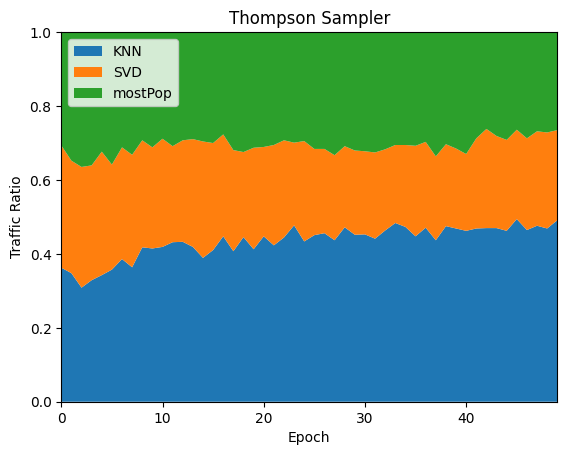

In [ ]:
# ### Calls to plot figures 1 & 2

# # fig2_bandit_traffic_ratios = defaultdict(dict, {'thompsonSampler': {'KNN': [10, 20, 30], 'SVD': [30, 20, 10], 'mostPop': [10, 10, 10]}, 'epsilonSampler': {'KNN': [10, 20, 30], 'SVD': [30, 20, 10], 'mostPop': [10, 10, 10]}})  # Example data
# print(fig1_cumulative_recall)
# plotFig1_3(fig1_cumulative_recall)
# print(fig2_bandit_traffic_ratios.items())

fig2_bandit_traffic_ratios = {'Thompson Sampler': {'KNN': [342, 328, 291, 310, 323, 337, 364, 343, 394, 391, 395, 407, 408, 395, 367, 387, 422, 384, 420, 389, 422, 399, 419, 450, 409, 425, 430, 412, 445, 426, 427, 416, 437, 456, 446, 422, 444, 412, 448, 442, 436, 442, 443, 443, 436, 466, 438, 449, 442, 463],
                                                   'SVD': [312, 287, 308, 293, 315, 268, 285, 287, 273, 258, 276, 245, 259, 275, 297, 273, 260, 258, 217, 259, 228, 256, 248, 211, 256, 220, 215, 217, 207, 215, 212, 220, 207, 199, 209, 231, 219, 214, 209, 204, 196, 230, 253, 235, 232, 228, 234, 241, 245, 230],
                                                   'mostPop': [289, 328, 344, 340, 305, 338, 294, 313, 276, 294, 272, 291, 276, 273, 279, 283, 261, 301, 306, 295, 293, 288, 276, 282, 278, 298, 298, 314, 291, 302, 304, 307, 299, 288, 288, 290, 280, 317, 286, 297, 311, 271, 247, 265, 275, 249, 271, 253, 256, 250]
}}

print(len(fig2_bandit_traffic_ratios['Thompson Sampler']['mostPop']))

for banditName, trafficCounts in fig2_bandit_traffic_ratios.items():
    trafficCountsDF = pd.DataFrame(trafficCounts)
    plotFig2(trafficCountsDF, banditName, 50)


In [ ]:
# for algName,alg in myAlgsFig1_3.items():
#     numCorrect[algName] = 0
#     fig1_cumulative_recall[algName] = []
#     if algName in ["thompsonSampler", "epsilonSampler", "ucbSampler"]:
#         for armName in alg.arms.keys():
#             print(f"Alg: {algName}, Arm: {armName}, Results: {fig2_bandit_traffic_ratios[algName][armName]}")

Alg: ucbSampler, Arm: KNN, Results: [943, 634, 575, 575, 594, 625, 629, 634, 637, 642, 646, 651, 655, 656, 656, 656, 656, 656, 656, 656, 656, 656, 656, 691, 692, 692, 692, 699, 705, 705, 705, 705, 705, 705, 705, 705, 705, 705, 705, 705, 705, 724, 691, 677, 677, 677, 677, 677, 677, 677, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 678, 686, 686, 686, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 687, 688, 672, 691, 674, 693]
Alg: ucbSampler, Arm: SVD, Results: [0, 309, 368, 195, 217, 143, 116, 94, 94, 94, 95, 95, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 127, 128, 128, 128, 129, 133, 133, 133, 133, 133, 134, 134, 134, 134, 134, 134, 134, 134, 142, 171, 184, 188, 188, 188, 188, 188, 188, 189, 189, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 190, 191, 191, 191, 191, 191, 191, 191, 195, 195, 195, 197, 197, 197, 197, 197, 197, 197, 197, 197, 199, 199, 199, 199, 199, 199, 199,

## Figure 3 Training and Plotting:


In [ ]:
'''
Delete old variables here to save space ?
'''
# print(cumulative_recall)

# del dynamic_ensemble_sampler
# del thompson_sampler
# del epsilon_sampler
# del ucb_sampler
# del myAlgsFig1_3

NameError: name 'cumulative_recall' is not defined

In [ ]:
# ### Fig3 Init

from surprise import KNNBasic, SVD, accuracy
import pandas as pd
import numpy as np

# As per the paper's definition of recall within this context
def recall(pred, numCorrect, algName, numRelevant):
    if algName == "mostPop":
        if pred > 5:
            numCorrect[algName] += 1
    else:
        if round(pred) in [4,5]:  # Correct pred
            numCorrect[algName] += 1
    print("numCorrect: " + str(numCorrect))
    print("numRelevant: " + str(numRelevant))
    print("Recall: " + str(numCorrect[algName] / numRelevant))
    return numCorrect[algName] / numRelevant

def precision(pred, numCorrect, algName, numRelevantPrecision):
    if algName == "mostPop":
        if pred > 5:
            numCorrect[algName] += 1
        else:
            numRelevantPrecision += 1
    else:
        if round(pred) in [4,5]:  # Correct pred
            numCorrect[algName] += 1
        else:
            numRelevantPrecision
    print("numCorrect: " + str(numCorrect))
    print("numRelevantPrecision: " + str(numRelevantPrecision))
    print("Recall: " + str(numCorrect[algName] / numRelevantPrecision))
    return numCorrect[algName] / numRelevantPrecision


### INIT VARS:

num_epochs = 25
# Dynamic Ensemble
fig3DynamicEnsembleArms = {
    "KNN": ExtendKNNBasic(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'SVD': ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "popularity": Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
}


# Define algs to use, metric report, cumulative recall scorekeeping
myAlgsFig3 = {
    "extendedKnnBasic": ExtendKNNBasic(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), k=len(uidSet), sim_options={'name': 'cosine', 'user_based': True}),
    'extendedSVD': ExtendSVD(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset), n_factors=20, n_epochs=20, lr_all=0.1),
    "popularity": Popularity(trainData=trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
    "random": Random(trainset.copy(deep=True), surprise_train=copy.deepcopy(surprise_trainset)),
    "dynamicEnsembleSampler" : DynamicEnsemble(trainset.copy(deep=True), iidSet, uidSet, fig3DynamicEnsembleArms)
}

## Init cumulative precision scorekeeping
fig3_cumulative_recall = defaultdict(dict)
fig3_cumulative_precision = defaultdict(dict)
fig3NumCorrect = defaultdict(dict)
fig3NumCorrect = defaultdict(dict)
for algName,_ in myAlgsFig3.items():
    fig3NumCorrect[algName] = 0
    fig3_cumulative_recall[algName] = []
    fig3_cumulative_precision[algName] = []
    fig3NumCorrect[algName] = 0
print(fig3_cumulative_recall)
print(fig3NumCorrect)

numCorrect = defaultdict(dict)
numRelevant= 0
numRelevantPrecision = 0

ratings = []

# # Get the number of relevant items within the initial testset
for (user_id, movie_id, rating) in surprise_testset:
    if rating >= 4:
      numRelevant += 1
      numRelevantPrecision += 1

print("numRelevant: ", numRelevant )

numRelevant:  52659


In [ ]:
### Train for Fig3

for algName,alg in myAlgsFig3.items():
    for epoch in range(num_epochs):
        # Fit, predict
        rewards = {}
        recs = {}
        if algName in ["random", "popularity", "extendedKnnBasic", "extendedSVD"]:
            print(algName)
            alg.fit(copy.deepcopy(surprise_trainset))
            recs = alg.recommend(uidSet)
        else:
            alg.fit()
            recs = alg.predict(uidSet)

        # For each rec, add to data or blacklist && calculate cumulative recall
        for uid, data in recs.items():
            armUsed = ""

            # Extract
            iid = data["iid"]
            if "armUsed" in data:
                armUsed = data["armUsed"]
                
            # Get rating
            rating = ratings_pivot.loc[uid,int(iid)]
            ratings.append(rating)

            if algName == 'dynamicEnsembleSampler':
                pred = data['est']
            else:
                pred = alg.predict(uid, iid).est
            
            # Update based on rating
            if not np.isnan(rating):  # A rating exists for this user, item pair
                if rating >= 4:  # Rating was good - thus prediction was good
                    fig3NumCorrect[algName] += 1
                    if armUsed != "":
                        alg.add_train_data(uid, iid, rating, armUsed, True)
                    else:
                        alg.add_train_data(uid, iid, rating, None, True)
                else:
                    alg.add_train_data(uid, iid, rating, armUsed, False)
            else:  # No rating for user, item. Blacklist from future recs
                alg.blacklist_item_from_user(uid, iid)

        # Updates alg w/ 
        alg.update()
        fig3_cumulative_recall[algName].append(recall(pred, fig3NumCorrect, algName, numRelevant))
        fig3_cumulative_precision[algName].append(precision(pred, fig3NumCorrect, algName, numRelevantPrecision))
        print(f"FINISHED EPOCH #", epoch)
    print("FINISHED ALG: ", algName)


numCorrect: defaultdict(<class 'dict'>, {'extendedKnnBasic': 1147, 'extendedSVD': 0, 'popularity': 0, 'random': 0, 'dynamicEnsembleSampler': 0})
numRelevantPrecision: 52659
Recall: 0.021781651759433335
FINISHED EPOCH # 7
extendedKnnBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
numCorrect: defaultdict(<class 'dict'>, {'extendedKnnBasic': 1290, 'extendedSVD': 0, 'popularity': 0, 'random': 0, 'dynamicEnsembleSampler': 0})
numRelevant: 52659
Recall: 0.024497236939554492
numCorrect: defaultdict(<class 'dict'>, {'extendedKnnBasic': 1291, 'extendedSVD': 0, 'popularity': 0, 'random': 0, 'dynamicEnsembleSampler': 0})
numRelevantPrecision: 52659
Recall: 0.024516227045709185
FINISHED EPOCH # 8
extendedKnnBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
numCorrect: defaultdict(<class 'dict'>, {'extendedKnnBasic': 1425, 'extendedSVD': 0, 'popularity': 0, 'random': 0, 'dynamicEnsembleSampler': 0})
numRelevant: 52659
Recall: 0.02706

In [ ]:
print(fig3_cumulative_recall)
print(fig3_cumulative_precision)

defaultdict(<class 'dict'>, {'extendedKnnBasic': [0.002487703906264836, 0.004994397918684366, 0.007577052355722668, 0.010577489128164226, 0.01327408420213069, 0.01593269906378777, 0.018781214986991777, 0.021762661653278642, 0.024497236939554492, 0.0270609012704381, 0.0293776942213107, 0.031998328870658385, 0.03459997341385138, 0.03720161795704438, 0.03963235154484514, 0.042044095026491195, 0.044436848401982566, 0.04675364135285516, 0.04910841451603715, 0.05102641523766118, 0.052944415959285215, 0.054729485937826394, 0.0564196053855941, 0.058413566531836915, 0.060369547465770335], 'extendedSVD': [0.0020889116770162744, 0.004785506750982738, 0.006855428321844319, 0.0086404983003855, 0.010406578172771986, 0.012058717408230312, 0.014090658766782506, 0.015856738639168994, 0.0175658481930914, 0.01912303689777626, 0.021022047513245597, 0.02280711749178678, 0.024402286408781025, 0.02603543553808466, 0.027763535198161757, 0.029320723902846617, 0.030498110484437606, 0.03213125961374124, 0.033783

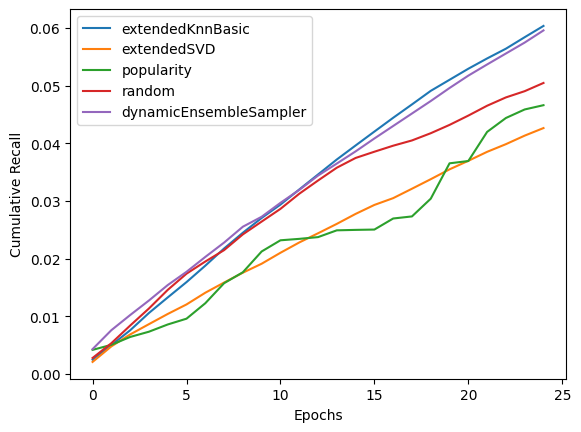

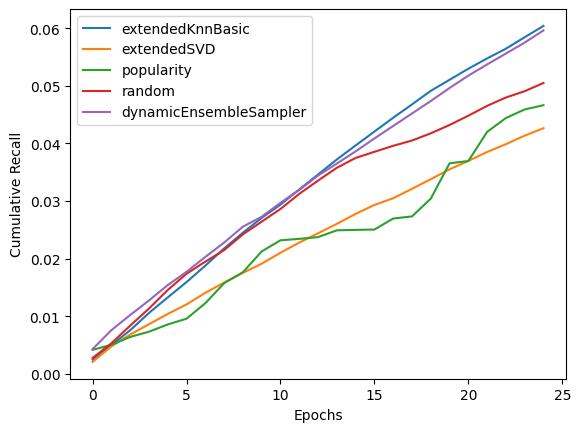

In [ ]:
### FIG3 PLOT:
plotFig1_3(fig3_cumulative_recall)
plotFig1_3(fig3_cumulative_precision)

## Fin.

[Link to Original Paper](https://dl.acm.org/doi/pdf/10.1145/3298689.3346984)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4dab19c-f282-48b5-937e-69d150c464bc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>